# Introduction

### Overview
This paper will be based on the Kaggle competition Real or Not? NLP with Disaster Tweets (https://www.kaggle.com/c/nlp-getting-started). It's an introductory challenge to serve as practice for Natural Language Processing with focus on Text Classification. The competition creators gathered 10875  tweets that are reporting an emergency or some man-made/natural disaster – the selection process is left unspecified. 


### Dataset
There are three provided files:
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - the framework for official competition submissions

The training dataset contains these columns:
- id: a unique numeric identifier for each tweet
- text: the actual content in the tweet
- keyword: keywords from the tweet manually selected by the competition creators (may be blank)
- location: the location the tweet was sent from (may be blank)
- target: values are hand classified by creators as either 0 for non-disaster or 1 for disaster

The test set is similar to the training data set except for not having a target column.
The sample_submission contains the id and a target column for all the tweets that competitors will have to populate with their proposed models.

### Goal
The challenge of the competition is to create a model that can most accurately predict the test set and achieve a high F1 Score (read more at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

For our team, however, we're hoping to use this challenge as our final academic opportunity to apply as many of the skills we've learned in our Practical Data Science Tutorial while exploring additional Data Science fields and methods we're interested in. 

Thus, we decided to create an NLP pipeline for this challenge, split it into four parts, and self-allocate as you will see in the Team Roles section below.

Important Note: We all worked on different sections of a pipeline, and those sections naturally vary in magnitude of required effort. Thus, while we consolidated efforts to create output that fed or flowed into each other's section, we each individually explored into aspects of the data or task that were not necessary for the pipeline.


### Team Roles
- Wei-Ting Yap: data exploration and pre-processing
- Emma Stiefel: data pre-processing and completion of data
- Nathan Torento (me): model creation and comparison
- Henry Biko: model evaluation

# Data exploration and pre-processing

To explore and pre-process the training dataset, Wei-Ting chose to use the open-source NLP library for Python called spaCy. It is a level up from the NLTK library in that it is object oriented rather than string processing, computationally faster, and provides more customizability.

There are an infinite permutation of implementations to preprocess text. Wei-Ting chose to pre-process the tweets such that for every tweet, she would take these steps:
- identify all # (hashtags)
- identify all @ (Twitter account mentions in-tweet)
- identify all URLs
- lowercase
- tokenize
- lemmatize
- remove stopwords
- bag of words

These are all standard NLP pre-processing steps, except Wei-Ting also considers the format and context of tweets by distinguishing the non-plain text that are likely to appear as well. Thus, she creates a Bag of Words for each row that counts the instances of text starting with #, text starting with @, URLs, and all lemmatize non-stop words.

#### For good measure, I would also remove emojis by searching and deleting all instances of their unicodes with regex.

Her final output, however, implements "count vectorization" - an extension on the Bag of Words (BoW) concept. 

### Count Vectorization
After creating a bag of words for every tweet, every "word" (or string) that has ever appeared is now added as a separate column of the dataset. Every row then places the number of times the strings in its lemmatized, non-stopword, bag of words appear for each column. This is a lengthy process to run on nearly 6000 tweets as it results in >20000 columns and a >200 mb dataset, so Wei-Ting saved the pre-processed .csv for easy access.

#### My only qualm with this manual count vectorization is that it scales the dataset dimensions and size exponentially, making it more computationally costly and timely to load and use the dataset. It took me nearly 10 minutes to load the training data each runtime. Thus, for the model section later, I slightly modify Wei-Ting's code.

# Data pre-processing and completion of data

Emma decided to take on the challenge of completely filling in the "location" section, as well as further spell-checking the dataset. 

### Location
Emma used the Mordecai library, which uses spaCy, Geonames, and the TensorFlow interact keras, to "Geoparse" the tweets. The library is often used to parse through text, identify information about geographical locations, then return these locations' coordinates.

#### Although not necessary for the tweet disaster classification pipeline, in real life, location is crucial information for emergency response and disaster response planning.

# Model creation and comparison

Nathan (me, writing in 3rd Person)

From all the possible classification models, Nathan chose to use the ones he had previous experience with:
- Logistic Regression
- Decision Tree
- Support Vector Machine
- Multinomial Naive Bayes Model

For each one, he implemented a simple implementation without any parameter specification.

He also implemented a deep neural network, for which he justifies his decisions for every layer.

For every model, he then compared the train accuracy, test accuracy, and F1 score.

In [96]:
#---[Adjusted] Pre-processing code from Wei-Ting---
import pandas as pd
import numpy as np

train = pd.read_csv('data/train.csv')

# Creating a new column in the train data containing the preprocessed text later
train.insert(loc=4, column="cleaned_text", value="")

In [97]:
train.head()

,id,keyword,location,text,cleaned_text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,,1


In [157]:
import re
import spacy 
import en_core_web_md

nlp = en_core_web_md.load()
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.add("-PRON-")

In [195]:
#features = set({'#','@','URL'}) # Using set feature to contain all words (lemmas) seen

# Now that we've preprocessed a single tweet, we can create a pre-process function for each tweet
def preprocess(s):
    """
    Given string s, spaCy model nlp, and set features (lemmas encountered),
    pre-process s and return updated features and bag-of-words representation dict freq
    - changes s to lower-case
    - remove punctuationo
    - tokenize s using nlp to create a doc
    - update features with lemmas encountered in s
    """
    # Split
    s = s.split()
    
    # Lowercase
    s = [word.lower() for word in s]
    
    # Remove non-letters
    s = [re.sub(r'[^a-zA-Z]', '', word) for word in s]
    
    # Remove non-letters
    s = [re.sub(r'[^\w\s]', '', word) for word in s]
    
    # spaCy conversion for lemmatization
    s = " ".join(s)
    s = nlp(s)
    
    # Lemmatization
    lemmas = [token.lemma_ for token in s]
        
    # Remove stopwords including -PRON
    # Note: spaCy lemmatizes all pronouns as -PRON-
    cleaned_lemmas = [word for word in lemmas if not word in stopwords]
    
    cleaned_lemmas = " ".join(cleaned_lemmas)
    
    return cleaned_lemmas

In [197]:
# Fill in cleaned_text column

for i in range(len(train)):
    train.loc[i, "cleaned_text"] = preprocess(train.loc[i, "text"])

train.head()

,id,keyword,location,text,cleaned_text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order cal...,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,send photo ruby alaska smoke wildfire pour school,1


In [308]:
# Store all unique words in our corpus

unique_words = {}

for text in train["cleaned_text"]:
    for word in text.split():
        if (word not in unique_words.keys()):
            unique_words[word] = 1
        else:
            unique_words[word] += 1
            
unique_words = pd.DataFrame.from_dict(unique_words, 
                                      orient="index", 
                                      columns=["frequency"])

unique_words.sort_values(by=["frequency"], inplace=True, ascending=False)

# for later use
total_unique_words = unique_words

unique_words.head(n=10)

,frequency
like,391
fire,359
amp,300
s,289
new,232
news,198
people,198
burn,174
video,174
kill,174


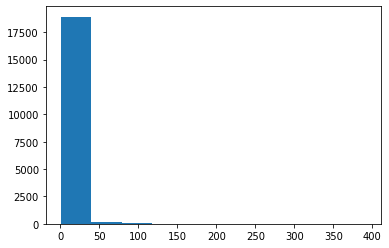

In [309]:
import matplotlib.pyplot as plt
# Let's see a histogram of the word frequencies
_ = plt.hist(unique_words['frequency'])

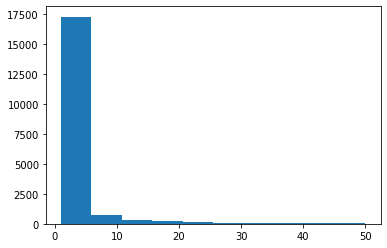

In [310]:
# Let's zoom in on the least frequently appearing words
_ = plt.hist(unique_words['frequency'], range = (1, 50))

In [311]:
# As you can see, there are many words that only appear once 
# or not often enough to improve the model so we will remove them
unique_words = unique_words[unique_words['frequency'] >= 10]
unique_words

,frequency
like,391
fire,359
amp,300
s,289
new,232
...,...
currently,10
wwii,10
bet,10
sunday,10


In [253]:
# Used the sklearn CountVectorizer function instead for computational efficiency
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer(max_features = unique_words.shape[0]).fit_transform(train["cleaned_text"].values).toarray()
bag_of_words

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [262]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = bag_of_words
y = train["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123)

print(f"""
X_train: {X_train.shape}
y_train: {y_train.shape}

X_test: {X_test.shape}
y_test: {y_test.shape}
""")


X_train: (6090, 1223)
y_train: (6090,)

X_test: (1523, 1223)
y_test: (1523,)



### Models
Now it's time to create the models. I will optimize for parameters wherever possible, but will minimize them as much as possible and set random state for replicability.

In [329]:
# Logistic Regression Model - lr
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression().fit(X_train,y_train)

In [294]:
# Decision Tree Model - dt
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train,y_train)

In [295]:
# Support Vector Machine Model - svc
from sklearn.svm import SVC

svc = SVC().fit(X_train,y_train)

In [296]:
# Multinomial Naive Bayes Model - mnb
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB().fit(X_train,y_train)

In [314]:
print(len(total_unique_words))

19171


The most number of pre-processed words to appear in a tweet is 137


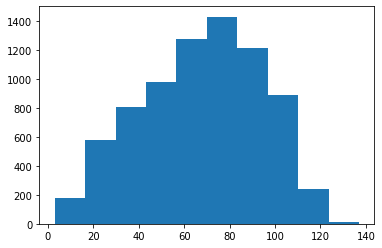

In [321]:
cleaned_text_count = [len(text) for text in train["cleaned_text"]]
_ = plt.hist(cleaned_text_count)
print(f"The most number of pre-processed words to appear in a tweet is {max(cleaned_text_count)}.")

A few notes about the final CountVectorizer-processed format of our input data:
- we are representing every tweet as a vector of 0 or 1 by whether the word appears, and each "column" is a unique word
- we removed the least frequent words because they won't help in identifying patterns and only increase the complexity of the computation
- X_train: (6090, 1223) and X_test: (1523, 1223), meaning I've decided that there are 1223 important unique words in our corpus that help indicate whether a tweet is a disaster or not

In real life, CNNs are often used for the task of text classification so long as the corpus is converted into some standardized vector of numbers. Without knowing this, I chose to use a convolutional neural networks because they are a popular go-to method for prediction problems, and they work well with image data-like input. Given that we applied the count vectorizer function on our data to produce a matrix of 0-1 values much like an image, a CNN is appropriate here. 

https://realpython.com/python-keras-text-classification/#convolutional-neural-networks-cnn
This is a great resource to further understand step-by-step how and why CNNs are used for the task of text classification.

These are the justifications for every layer I add in my convolutional neural network:

> Embedding layer <br> <br>
Rationale: Maps integer representation of words (in our case, Count Vectorized form) into vector representationsn whose distinct values can be further analyzed to find patterns; often this is set to 32, 50, 100, or more; I choose 100 in this case <br> <br>
Parameters:
>- input_dim = the max number of distinct words or values in each input vector
>- output_dim = the amount of vectors to process
>- input_length = the length of each row (or the overall amount of words in each vector)
<br> <br>
> Read more: https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

> Convolutional layer <br> <br>
Rationale: Transform the inputs from the previous layer to detect specific features from the appearance of unique word combinations against each other that indicate a "disaster" or not <br> <br>
Parameters:
>- filters = the number of output filters or convolutions; defaults include 32 or 100; I choose 100 in this case
>- kernel_size = length of each convolution; I chose a default 5
>- activation = "relu" for a computationally cheaper activation
<br> <br>
> Read more: https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12

> A flattening layer <br> <br>
Rationale: to prepare the output from the convolutional layer for the Dense layer

> Two dense layers <br> <br>
Rationale: the first layer deepens the CNN to further identify similar patterns in the previous layers; the second is the final binary classifying node <br> <br>
Parameters: 
>- activation = "relu" computationally cheaper for the larger layer, and "sigmoid" for the final layer to outputs a number between 0 to 1 as required for the classification task

In [326]:
# Convolutional Neural Network Model - dnn
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

cnn = Sequential()


cnn.add(Embedding(input_dim=137, 
                    output_dim=100, 
                    input_length=1223))
cnn.add(Conv1D(filters=100, 
                 kernel_size=5, 
                 activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

cnn.compile(optimizer='adam', 
              loss="binary_crossentropy",
              metrics=['accuracy'])

cnn.fit(X_train, y_train, 
          epochs=10, 
          verbose=1)

Epoch 1/10
191/191 [==============================] - 67s 349ms/step - loss: 0.5676 - accuracy: 0.7105
Epoch 2/10
191/191 [==============================] - 68s 354ms/step - loss: 0.4065 - accuracy: 0.8166
Epoch 3/10
191/191 [==============================] - 63s 329ms/step - loss: 0.3399 - accuracy: 0.8539
Epoch 4/10
191/191 [==============================] - 67s 352ms/step - loss: 0.2815 - accuracy: 0.8791
Epoch 5/10
191/191 [==============================] - 63s 329ms/step - loss: 0.2234 - accuracy: 0.9079
Epoch 6/10
191/191 [==============================] - 64s 333ms/step - loss: 0.1705 - accuracy: 0.9366
Epoch 7/10
191/191 [==============================] - 58s 304ms/step - loss: 0.1352 - accuracy: 0.9491
Epoch 8/10
191/191 [==============================] - 60s 316ms/step - loss: 0.1140 - accuracy: 0.9581
Epoch 9/10
191/191 [==============================] - 58s 306ms/step - loss: 0.0985 - accuracy: 0.9619
Epoch 10/10
191/191 [==============================] - 62s 324ms/step - l

NameError: name 'test_x' is not defined

# Simple Model Evaluation
This is a section left for Henry, but simply based on the provided metric, these are the performances of all the models.

In [ ]:
# List of models for future reference
model_list = [('Logistic Regression', lr),
              ('Decision Tree', dt),
              ('Support Vector Machine', svc),
              ('Multinomial Naive Bayes Model', mnb),
              ('Convolutional Neural Network', cnn)]

In [345]:
from sklearn.metrics import f1_score

train_scores = []
test_scores = []
f1_scores = []
for model in model_list[:4]:
    train_score = model[1].score(X_train, y_train)
    train_scores.append(train_score)

    test_score = model[1].score(X_test, y_test)
    test_scores.append(test_score)
    
    y_pred = model[1].predict(X_test)
    _f1_score = f1_score(y_test, y_pred)
    f1_scores.append(_f1_score)
    
    print(f"""
    {model[0]}
    Train Score: {train_score}
    Test Score: {test_score}
    F1 Score: {_f1_score}
    """)


    Logistic Regression
    Train Score: 0.8566502463054187
    Test Score: 0.7977675640183848
    F1 Score: 0.7416107382550335
    

    Decision Tree
    Train Score: 0.9745484400656814
    Test Score: 0.7150361129349967
    F1 Score: 0.6488673139158576
    

    Support Vector Machine
    Train Score: 0.9082101806239737
    Test Score: 0.7964543663821405
    F1 Score: 0.7318339100346021
    

    Multinomial Naive Bayes Model
    Train Score: 0.8154351395730706
    Test Score: 0.7925147734734077
    F1 Score: 0.7371048252911814
    


In [ ]:
# CNN (different library so must specify/compute values differently)

In [346]:
train_score = 0.9626
test_score = cnn.evaluate(X_test, y_test)[1]

48/48 [==============================] - 4s 89ms/step - loss: 1.0058 - accuracy: 0.7656


In [378]:
y_pred = cnn.predict_classes(X_test)
y_pred = y_pred.flatten()

In [379]:
_f1_score = f1_score(y_test, y_pred)

In [384]:
# Append values to corresponding lists
train_scores.append(train_score)
test_scores.append(test_score)
f1_scores.append(_f1_score)

In [396]:
print(f"""
    {model_list[4][0]}
    Train Score: {train_score}
    Test Score: {test_score}
    F1 Score: {_f1_score}
    """)


    Convolutional Neural Network
    Train Score: 0.9626
    Test Score: 0.7655942440032959
    F1 Score: 0.7056883759274527
    


# Final Model Scores

In [401]:
model_names = [model[0] for model in model_list]
final_scores = {'Model': model_names,
               'Train Score': train_scores,
               'Test Score': test_scores,
               'F1 Score': f1_scores}

final_scores = pd.DataFrame(final_scores)
final_scores['Train Score'] = final_scores['Train Score'].round(3)
final_scores['Test Score'] = final_scores['Test Score'].round(3)
final_scores['F1 Score'] = final_scores['F1 Score'].round(3)

final_scores

,Model,Train Score,Test Score,F1 Score
0,Logistic Regression,0.857,0.798,0.742
1,Decision Tree,0.975,0.715,0.649
2,Support Vector Machine,0.908,0.796,0.732
3,Multinomial Naive Bayes Model,0.815,0.793,0.737
4,Convolutional Neural Network,0.963,0.766,0.706


Ultimately, the logistic regression does the best in terms of both test and f1 score.

This is not surprising in the realm of Data Science. Just because it is conceptually simple to grasp and easy to implement, does not necessarily mean it performs the poorest compared to other algorithms. 

Then again, the test and f1 values for all the models range around 0.7, so it could be argued that further optimization of each model would, though timely, produce more numerically spread and thus more comparable results.

Either way, this is an exploration for Henry to build upon.

# Sources

Abdullah, M. (2020, January 01). Disaster Tweets Solution. Retrieved from https://www.kaggle.com/mohamedabdullah/disaster-tweets-solution

Choubey, V. (2020, July 22). Text classification using CNN. Retrieved from https://medium.com/voice-tech-podcast/text-classification-using-cnn-9ade8155dfb9

Malik, U. (2019). Python for NLP: Word Embeddings for Deep Learning in Keras. Retrieved from https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

Pantola, P. (2018, June 14). Natural Language Processing: Text Data Vectorization. Retrieved from https://medium.com/@paritosh_30025/natural-language-processing-text-data-vectorization-af2520529cf7

Wang, S. (2018, April 13). Build a Text Classification Program: An NLP Tutorial. Retrieved from https://www.toptal.com/machine-learning/nlp-tutorial-text-classification